<a href="https://colab.research.google.com/github/soohyunme/TensorFlow_Tutorial/blob/main/Code/12_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Device setting

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0],True)

# Image loading with TFDS

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train','test'], # if data have validation ['train','valid','test'],
    shuffle_files=True,
    as_supervised=True, # will return tuple (img, label) otherwise dict
    with_info=True, # able to get info about dataset
)


## Dataset Info check

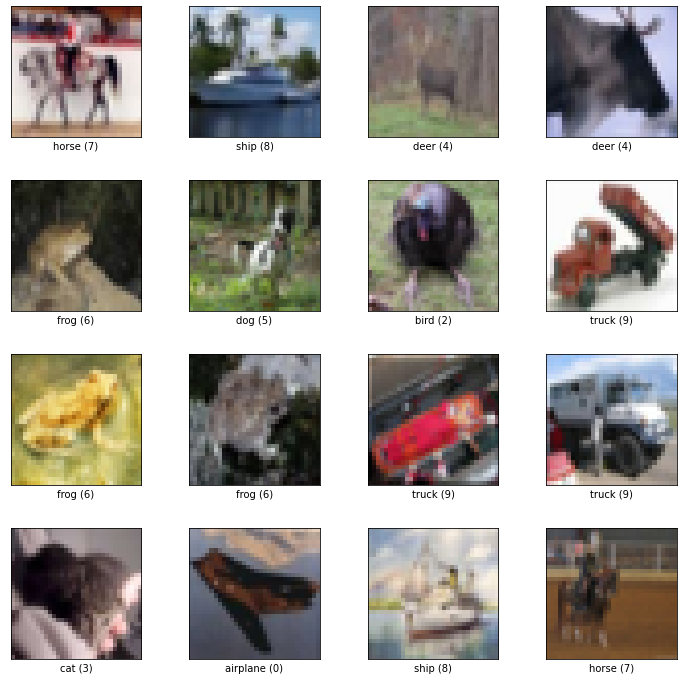

In [ ]:
fig = tfds.show_examples(ds_train, ds_info, rows=4, cols=4)

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.2,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)



# Normalizes images

In [ ]:
def normalize_img(image, label):
  # normalize images
  return tf.cast(image, tf.float32)/255.0, label

# Hyperparameters

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

# Augmentation

예제에서는 사이즈가 동일하지만 image의 크기가 다를 수도 있으므로 image를 resize 하는 과정을 거침


In [ ]:
def augment(image, label):
    new_height = new_width = 32
    image = tf.image.resize(image, (new_height, new_width))

    if tf.random.uniform((), minval=0, maxval=1) < 0.1: # 10%의 확률로 grayscale 변환
      image = tf.tile(tf.image.rgb_to_grayscale(image),[1, 1, 3]) # input shape를 맞춰주기 위해 채널 복제
    
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)

    # 이미지를 flip, rotation 할 때 데이터의 형태를 유의해야함.
    # 예로 mnist 데이터의 9의 경우 180도 돌릴 경우 6이 되기 때문에
    # label과 일치하지 않게 됨
    
    image = tf.image.random_flip_left_right(image) # 50%
    # image = tf.image.random_flip_up_down(image) # 50%

    return image, label


# Setup for train dataset

In [ ]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.map(augment, num_parallel_calls=AUTOTUNE) # Augmentaion
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

# setup for test dataset

In [ ]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(AUTOTUNE)

# Build model

In [ ]:
model = keras.Sequential(
    [
    keras.Input((32, 32, 3)),
    layers.Conv2D(4, 8, padding='same', activation='relu'),
    layers.Conv2D(8, 8, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16, 8, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10),
     ]
)

model.compile(
    optimizer = keras.optimizers.Adam(3e-4),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)
model.fit(ds_train, epochs=5, verbose=2)
model.evaluate(ds_test)

Epoch 1/5
1563/1563 - 27s - loss: 2.0746 - accuracy: 0.2212 - 27s/epoch - 17ms/step
Epoch 2/5
1563/1563 - 13s - loss: 1.8707 - accuracy: 0.3129 - 13s/epoch - 8ms/step
Epoch 3/5
1563/1563 - 13s - loss: 1.7676 - accuracy: 0.3585 - 13s/epoch - 8ms/step
Epoch 4/5
1563/1563 - 13s - loss: 1.7121 - accuracy: 0.3790 - 13s/epoch - 8ms/step
Epoch 5/5
1563/1563 - 13s - loss: 1.6696 - accuracy: 0.3975 - 13s/epoch - 8ms/step
79/79 [==============================] - 3s 32ms/step - loss: 4.1766 - accuracy: 0.2676


[4.176586627960205, 0.26759999990463257]

Augmentation 미적용

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train','test'], # if data have validation ['train','valid','test'],
    shuffle_files=True,
    as_supervised=True, # will return tuple (img, label) otherwise dict
    with_info=True, # able to get info about dataset
)

In [ ]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(AUTOTUNE)

In [ ]:
model = keras.Sequential(
    [
    keras.Input((32, 32, 3)),
    layers.Conv2D(4, 8, padding='same', activation='relu'),
    layers.Conv2D(8, 8, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16, 8, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10),
     ]
)

model.compile(
    optimizer = keras.optimizers.Adam(3e-4),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)
model.fit(ds_train, epochs=5, verbose=2)
model.evaluate(ds_test)

Epoch 1/5
1563/1563 - 21s - loss: 1.6577 - accuracy: 0.4075 - 21s/epoch - 13ms/step
Epoch 2/5
1563/1563 - 8s - loss: 1.3765 - accuracy: 0.5095 - 8s/epoch - 5ms/step
Epoch 3/5
1563/1563 - 8s - loss: 1.2515 - accuracy: 0.5555 - 8s/epoch - 5ms/step
Epoch 4/5
1563/1563 - 8s - loss: 1.1626 - accuracy: 0.5891 - 8s/epoch - 5ms/step
Epoch 5/5
1563/1563 - 8s - loss: 1.0915 - accuracy: 0.6149 - 8s/epoch - 5ms/step
79/79 [==============================] - 3s 33ms/step - loss: 1.1795 - accuracy: 0.5877


[1.1795430183410645, 0.5877000093460083]

# TF >= 2.3.0

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train','test'], # if data have validation ['train','valid','test'],
    shuffle_files=True,
    as_supervised=True, # will return tuple (img, label) otherwise dict
    with_info=True, # able to get info about dataset
)

In [ ]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.Resizing(height=32, width=32),
     layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
     layers.experimental.preprocessing.RandomContrast(factor=0.1)
    ]
)

In [ ]:
model = keras.Sequential(
    [
    keras.Input((32, 32, 3)),
    data_augmentation,
    layers.Conv2D(4, 8, padding='same', activation='relu'),
    layers.Conv2D(8, 8, padding='same', activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(16, 8, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10),
     ]
)

model.compile(
    optimizer = keras.optimizers.Adam(3e-4),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)
model.fit(ds_train, epochs=5, verbose=2)
model.evaluate(ds_test)

Epoch 1/5
1563/1563 - 23s - loss: 1.7007 - accuracy: 0.3859 - 23s/epoch - 15ms/step
Epoch 2/5
1563/1563 - 11s - loss: 1.4087 - accuracy: 0.4955 - 11s/epoch - 7ms/step
Epoch 3/5
1563/1563 - 11s - loss: 1.2880 - accuracy: 0.5425 - 11s/epoch - 7ms/step
Epoch 4/5
1563/1563 - 11s - loss: 1.2091 - accuracy: 0.5739 - 11s/epoch - 7ms/step
Epoch 5/5
1563/1563 - 11s - loss: 1.1414 - accuracy: 0.5962 - 11s/epoch - 7ms/step
79/79 [==============================] - 3s 34ms/step - loss: 1.1493 - accuracy: 0.5921


[1.1493195295333862, 0.5921000242233276]